## Grupo de trabajo

- John Franklin Gonzalez Gamboa - 201725981
- Jorge Eduardo Rodriguez Cardozo - 200711501
- German Augusto Carvajal Murcia - 201313516

# Project 2
## Image Classification with CNN
-------------------------------


Having downloaded the compress database of images, the first step is to unzip the folder of archives to enable faster access to the individual images during the project execution.

In [1]:
#!unzip birds.zip > /dev/null

As an additional step, and with knowledge of possible warnings due to the file sizes or properties we disable all user warnings in order to improve readability of the notebook.

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Direct prediction
   * Download the dataset birds from http://www-cvr.ai.uiuc.edu/ponce_grp/data/.
   * Use [Keras](https://keras.io/) and a CNN from Keras [Applications](https://keras.io/applications/) pretrained on ImageNet, to classify the images in the birds dataset. Construct a confusion matrix that relates the bird classes with the 10 most frequent classes from ImageNet predicted by the model.
   * Discuss the results.

Considering the different Keras applications sizes, we decided to use the VGG16 pre-trained model with the ImageNet weights as our baseline classifier. The dense layers (top) of the model is included because it will not be used as a feature extractor but as a direct prediction tool.

In [3]:
import os
from keras.applications.vgg16 import VGG16
model_vgg16=VGG16(weights='imagenet',include_top=True)

Using TensorFlow backend.


The following function presents in an easily readable format the current state of an iterative long process. Due to the nature of neural networks, this most likely will be the case with images importing and prediction, so we'll use it to have betetr control of the workflow pace.

In [4]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

The images are loaded in memory one by one, and according to the base `Birds`database with the individual files stored within folders for each of the 6 possible classes.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img

classes=os.listdir("birds")#!ls birds
image_list = np.empty((600,224,224,3))
class_list = []
n=0
for i in classes:
    listI=os.listdir('birds/'+i)
    for j in range(len(listI)):
        Path='birds/'+i+'/'+listI[j]
        img = load_img(Path,target_size=(224,224))  # this is a PIL image
        x = img_to_array(img)  # this is a Numpy array with shape (224, 224,3)
        x = x.reshape((1,) + x.shape)
        image_list[n]=x
        class_list.append(i)
        n=n+1
        printProgressBar(n,600,prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The correct image loading process is verified transforming the stored matrices - once again - into an image. The following is the example for the $600th$ image loaded into memory.

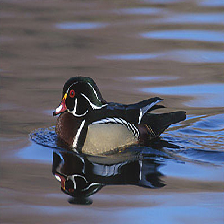

In [6]:
from keras.preprocessing.image import array_to_img
array_to_img(image_list[599])

With the loaded matrices for the RGB standard of the folder images, the default VGG16 model is used to predict the classes.

In [7]:
predict_list=model_vgg16.predict(image_list,verbose=1)

600/600 [==============================] - 395s 659ms/step


The prediction vector returns a (1000 {1000}) array where each posittion of the higher level index has an inner array with probabilities for the thousand classes wich the VGG16 model is trained to predict. Thus, the prediction are decoded to extract the original predicted classes, and as an adition step, the top ten predicted classes are extracted to simplify the presentation of the required confusion matrix.

In [8]:
from keras.applications.vgg16 import decode_predictions
predicted_classes5=decode_predictions(predict_list)
predicted_classes=[]
for i in range(600):
    predicted_classes.append(predicted_classes5[i][0][1])
from collections import Counter
mc = []
for i in range(10):
    mc.append(Counter(predicted_classes).most_common(10)[i][0])
for i in range(600):
    if(predicted_classes[i] not in mc):
        predicted_classes[i]='Other'

The final confusion matrix obtained with the predictions of the default VGG16 model is presented in the next block. In it we can see the model predict with a very high accuracy the America egreet bird family, but all the other classes lack in comparison, possibly due to the fact that the model is not precisely calibrated to the classify this particular set of input files.

In [9]:
import pandas as pd
d={'Real': class_list,'Prediccion': predicted_classes,'Objeto':range(600)}
results=pd.DataFrame(d)
pd.pivot_table(results,values='Objeto',index=['Prediccion'],columns=['Real'],aggfunc='count',margins=True).sort_values('All').fillna('')

Real,egret,mandarin,owl,puffin,toucan,wood_duck,All
Prediccion,,,,,,,
kite,,1,8,1,,,10
king_penguin,,,,11,,,11
pelican,1,10,,1,,,12
snorkel,,3,,1,,8,12
magpie,,1,,15,,,16
albatross,,1,3,24,,,28
ptarmigan,,,41,7,,,48
drake,,23,,5,,37,65
American_egret,82,2,,,,,84


## 2. Transfer learning
   * Use the pre-trained CNN model as a feature extractor. Create a new model that replaces the top part of the pretrained CNN with two layers of 256 and 6 neurons respectively.
   * Train the model with the training images from the bird dataset. 
   * Evaluate the performance over the test dataset reporting the results in a confusion matrix. Discuss the results. 

Transfer learning requieres to train a model to replace the dense layers of an original Application. As with every trining process, it is necesary to divide the database into the trainig, validation and test sets, most notably with neural networks due to their tendency to overfit the data. Considering the database size and its folders-in folders structure we first separate the file-paths into the correct samples-group (train, validation, test). The split rates used for this process were:
- Train: 50%
- Validation: 30%
- Test: 20%

In [10]:
from sklearn.model_selection import train_test_split
path_train=[]
path_validation=[]
path_test=[]
class_train=[]
class_validation=[]
class_test=[]
for i in classes:
    listI=os.listdir('birds/'+i)
    Paths=[]
    cate=[]
    for j in range(len(listI)):
        Paths.append('birds/'+i+'/'+listI[j])
        cate.append(i)
    trainP, tempP, trainC, tempC = train_test_split(Paths,cate,test_size=0.5,random_state=123)
    valiP, testP, valiC, testC = train_test_split(tempP,tempC,test_size=0.4,random_state=123)
    path_train.extend(trainP)
    path_validation.extend(valiP)
    path_test.extend(testP)
    class_train.extend(trainC)
    class_validation.extend(valiC)
    class_test.extend(testC)
print('Train: ',len(path_train))
print('Validation: ',len(path_validation))
print('Test: ',len(path_test))

Train:  300
Validation:  180
Test:  120


The three following blocks of code load into an appropriate array the images corresponding to each of the sample-groups. The process is exacuted with the file paths divided and stored in the previous block of code.

Train data loading:

In [11]:
image_list_train = np.empty((len(path_train),224,224,3))
n=0
for Path in path_train:
    img = load_img(Path,target_size=(224,224))  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (224, 224,3)
    x = x.reshape((1,) + x.shape)
    image_list_train[n]=x
    n=n+1
    printProgressBar(n,len(path_train),prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Validation data loading:

In [12]:
image_list_validation = np.empty((len(path_validation),224,224,3))
n=0
for Path in path_validation:
    img = load_img(Path,target_size=(224,224))  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (224, 224,3)
    x = x.reshape((1,) + x.shape)
    image_list_validation[n]=x
    n=n+1
    printProgressBar(n,len(path_validation),prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Test data loading:

In [13]:
image_list_test = np.empty((len(path_test),224,224,3))
n=0
for Path in path_test:
    img = load_img(Path,target_size=(224,224))  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (224, 224,3)
    x = x.reshape((1,) + x.shape)
    image_list_test[n]=x
    n=n+1
    printProgressBar(n,len(path_test),prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


As with the direct prediction exercise, the images are reconstructed from thier array representation to verify thier correct loading into the workspace. The next three images correspong to the $100th$ read image for each of the sample-groups.

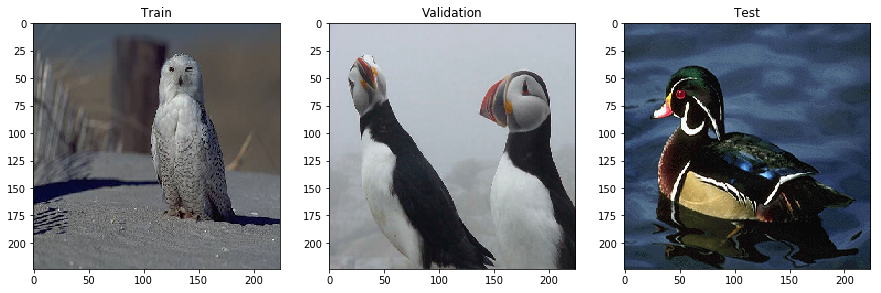

In [14]:
plt.figure(1,figsize=(15, 20))
plt.subplot(131)
plt.title('Train')
plt.imshow(array_to_img(image_list_train[100]))
plt.subplot(132)
plt.title('Validation')
plt.imshow(array_to_img(image_list_validation[100]))
plt.subplot(133)
plt.title('Test')
plt.imshow(array_to_img(image_list_test[100]))

Because we'll train a new model to replace the top of the application, is requiered to encode the classes into a binary array were each feauture is an indicator for one-class. To ensure that all the sample-groups of images are being encoded in the same order the SciKit-Learn Label-binarizer is used over each the output arrays.

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(class_train)
Y_train = lb.transform(class_train)
Y_validation = lb.transform(class_validation)
Y_test = lb.transform(class_test)

In correspondence to the direct prediction exercise, this transfer learning will be done with the same pre-trained VGG16 model to enable performance comparisons. In this case the top is excluded due to the fact the the model is going to be integrated as a feature extractor into a new calibrated dense layer.

In [16]:
model_vgg16=VGG16(weights='imagenet',include_top=False)

Because of the model being implemented as a feature extractor, the prediction for each of the sample-groups are stored into an intermadiate variable to avoid reprocessing and reduce computational time recalculating unnecesary tensors.

In [17]:
X_input_train=model_vgg16.predict(image_list_train,verbose=1)
X_input_validation=model_vgg16.predict(image_list_validation,verbose=1)
X_input_test=model_vgg16.predict(image_list_test,verbose=1)

120/120 [==============================] - 68s 570ms/step


To correctly set the input layer of the new 'top', we get the prediction dimensions of the feature extraction. In this case, the output for each image is a `(7,7,512)` tensor.

In [18]:
X_input_train.shape

(300, 7, 7, 512)

The new dense layer for the integrated model is build with the following sequential characteristics:

1. Input layer for `(7,7,512)` features
2. First hidden layer with 256 neurons and a relu activation function
3. Dropout of 0.5 for the trainig process
4. An output layer of 6 neurons (one for each class) with a softmax activation function

The model is trained using the RMSprop optimizer with a calibrated learning rate set to $0.0001$. The chosen loss-function is the categorical-crossentropy and the accuracy is also computed. At the end of a 100 epochs trainig process with batches of 32 images the final accuracy over the test data (independent of the train and validation sets) soars to over 94.16%, a significant improvement over the direct prediction exercise.

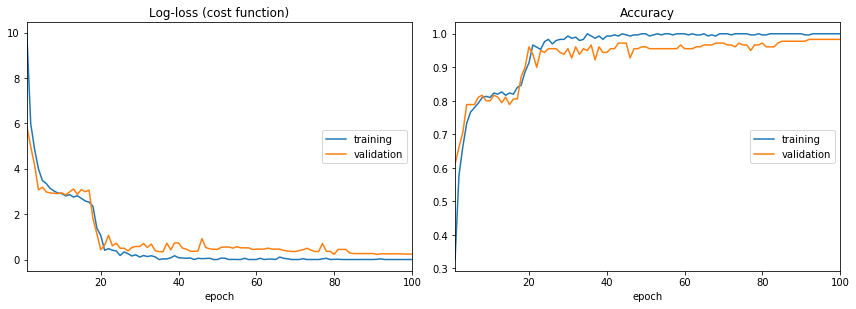

120/120 [==============================] - 0s 421us/step
Test score: 0.3863021691640218
Test accuracy: 0.9583333293596904


In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras

np.random.seed(123)
tf.set_random_seed(123)
rmsprop=RMSprop(lr=0.0001)
model=Sequential()
model.add(Flatten(input_shape=(7,7,512)))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.compile(optimizer=rmsprop,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(X_input_train,Y_train,batch_size=32,epochs=100,verbose=0,validation_data=(X_input_validation,Y_validation),callbacks=[PlotLossesKeras()])
score=model.evaluate(X_input_test,Y_test,verbose=1)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

To build the confussion matrix, in this case is only necesary to ask the model the predicted classes (considering it has been trained with the right classes of this dataset), adn decode them into strings according to their order.

In [20]:
pr_class=model.predict_classes(X_input_test)
predicted_classes = []
for i in pr_class:
    predicted_classes.append(classes[i])

The resulting confusion matrix over the test set shows the impresive prediction power of the model, correctly classifing all of the egret and toucan birds. At the sime time, for the other three classes except the mandarin species the error rate is just 5%. The worst performing classificaion class was the mandarin species with an error in 20% of the samples, then creating a space for improvement by using the fine-tunning strategy.

In [21]:
d={'Real': class_test,'Prediccion': predicted_classes,'Objeto':range(len(pr_class))}
results=pd.DataFrame(d)
pd.pivot_table(results,values='Objeto',index=['Prediccion'],columns=['Real'],aggfunc='count',margins=True).fillna('')

Real,egret,mandarin,owl,puffin,toucan,wood_duck,All
Prediccion,,,,,,,
egret,20,,,,,,20
mandarin,,17,,,,,17
owl,,,20,,,,20
puffin,,2,,20,,1,23
toucan,,,,,19,,19
wood_duck,,1,,,1,19,21
All,20,20,20,20,20,20,120


   ## 3. Fine tuning
   * Repeat the experiment from the last question, but this time allow all the layers to be trained. 
   * Compare and discuss the results.

In [22]:
from keras.applications import VGG16
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img

np.random.seed(123)
tf.set_random_seed(123)

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001EE80008438> False
<keras.layers.convolutional.Conv2D object at 0x000001EE83445B70> False
<keras.layers.convolutional.Conv2D object at 0x000001EE930484E0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001EE931C5EF0> False
<keras.layers.convolutional.Conv2D object at 0x000001EE83276E10> False
<keras.layers.convolutional.Conv2D object at 0x000001EE8320B6D8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001EE93169EB8> False
<keras.layers.convolutional.Conv2D object at 0x000001EE83169EB8> False
<keras.layers.convolutional.Conv2D object at 0x000001EE9337CCF8> False
<keras.layers.convolutional.Conv2D object at 0x000001EE9337FBA8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001EE96F127F0> False
<keras.layers.convolutional.Conv2D object at 0x000001EE96F02AC8> False
<keras.layers.convolutional.Conv2D object at 0x000001EE93008940> False
<keras.layers.convolutional.Conv2D object at 0x000001EE92FD5390> False
<ker

In [23]:
from keras import models
from keras import layers
from keras import optimizers

np.random.seed(123)
tf.set_random_seed(123)
 
# Create the model
model4 = models.Sequential()
 
# Add the vgg convolutional base model
model4.add(vgg_conv)
 
# Add new layers
model4.add(layers.Flatten())
model4.add(layers.Dense(1024, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 25,697,286
Non-trainable params: 14,714,688
_________________________________________________________________


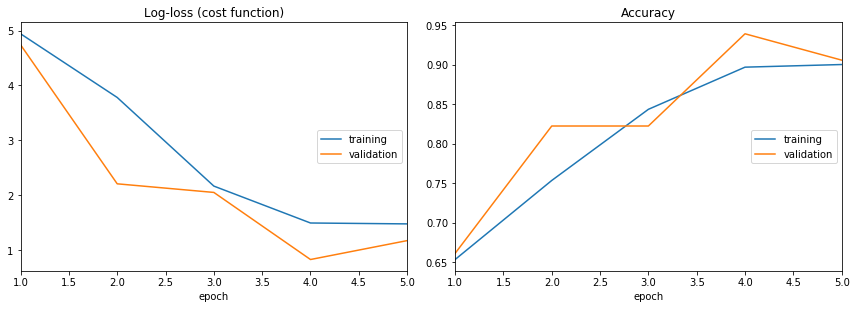

120/120 [==============================] - 85s 712ms/step
Test score: 1.7624894380569458
Test accuracy: 0.875000003973643


In [25]:
np.random.seed(123)
tf.set_random_seed(123)

# Compile the model
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])
# Train the model
history=model4.fit(image_list_train,Y_train,batch_size=16,epochs=5,verbose=0,validation_data=(image_list_validation,Y_validation),callbacks=[PlotLossesKeras()])
 
# Save the model
model4.save('small_last4.h5')

score=model4.evaluate(image_list_test,Y_test,verbose=1)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

The difference between Transfer Learning and Fine-Tuning is that in Transfer Learning we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

For the first tests, the same topology of the network used in the secund part was used with low performance results. After several iterations, the best combination found was to use the VGG16 model without the upper layer and to fix the values of all the layers except the last one: keras.layers.pooling.MaxPooling2D. In addition, a layer of 1024 neurons with relu activation, 0.5 dropout and a dense layer of 6 neurons, softmax was used to assign the final results.

With this topology in only 5 ephocs we had a test accuracy of 0.875. This value is lower than in the previous exercise, but the results are not comparable given the low amount of epochs that were run in this experiment. If we compare the result of the fifth epoch for the 2 models we can find that fine tuning has better performance with an increase of 10 percentage points.